In [1]:
import torch, torch.utils.data
from torch import nn
import torchvision, torchvision.datasets
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List

import sys
sys.path.append('./fedlab/main/fedlab_benchmarks/leaf/')

sys.path.append('./fedlab/main/fedlab_benchmarks/')

sys.path.append('./fedlab/main/')

sys.path.append('./fedlab/')

from fedlab.main.fedlab_benchmarks.leaf.dataloader import get_LEAF_dataloader

from torch.profiler import profile, record_function, ProfilerActivity
import time
from sklearn.metrics import f1_score   
import numpy as np
    
import random

In [2]:
print(torch.__version__)




2.0.1+cu117


In [3]:

train_loaders = []
test_loaders = []
num_nodes = 5
num_class = 10
epoch_total = 50
pickle_name = "mnist-P2P-epoch-"+str(epoch_total)

In [4]:
device = torch.device('cuda')
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 3070 Ti Laptop GPU'

In [5]:

transform = transforms.Compose([
    transforms.ToTensor(),
])
target_transform = lambda x: torch.nn.functional.one_hot(torch.tensor(x),num_class).float()

In [6]:
# def split_dataset(dataset, n):
#     torch.utils.data.random_split(dataset, )

In [7]:
# train_dataset2 = torchvision.datasets.MNIST('datasets/', download=True, train=True, transform=transform, target_transform=target_transform),
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000000, num_workers=0)

# test_dataset = torchvision.datasets.MNIST('datasets/', download=True, train=False, transform=transform, target_transform=target_transform)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000000, num_workers=0)


# Inital MNIST
train_datasets = torch.utils.data.random_split(torchvision.datasets.MNIST('datasets/',
                                                                           download=True, train=True, transform=transform, target_transform=target_transform), [1/num_nodes]*num_nodes)
test_datasets = torch.utils.data.random_split(torchvision.datasets.MNIST('datasets/',
                                                                           download=True, train=False, transform=transform, target_transform=target_transform), [1/num_nodes]*num_nodes)

train_loaders = [torch.utils.data.DataLoader(i, batch_size=1000000, num_workers=0, pin_memory=True) for i in train_datasets]
test_loaders = [torch.utils.data.DataLoader(i, batch_size=1000000, num_workers=0, pin_memory=True) for i in test_datasets]


In [8]:
print(len(train_loaders))
print(len(test_loaders))
print(test_loaders)
print(len(test_loaders[0].dataset))

5
5
[<torch.utils.data.dataloader.DataLoader object at 0x0000022ADC432230>, <torch.utils.data.dataloader.DataLoader object at 0x0000022ADC433CA0>, <torch.utils.data.dataloader.DataLoader object at 0x0000022ADC433F10>, <torch.utils.data.dataloader.DataLoader object at 0x0000022AC544BEE0>, <torch.utils.data.dataloader.DataLoader object at 0x0000022AC544BE80>]
2000


In [9]:

x_i_j = {}
s_i = {}

ypred = []
ylabels = []
ypred_test = []
ylabels_test = []

In [10]:
class FederatedNode:
    def __init__(self, train_dataloader, test_dataloader, node_id) -> None:
        self.dataset_size = len(train_dataloader.dataset)
        channels_sum, channels_squared_sum, num_batches = 0, 0, 0
        for data, _ in train_dataloader:
            # Mean over batch, height and width, but not over the channels
            channels_sum += torch.mean(data, dim=[0])
            channels_squared_sum += torch.mean(data**2, dim=[0])
            num_batches += 1
    
        self.mean = channels_sum / num_batches
        self.test_loss = 0.0
        self.test_accuracy = 0.0
        self.train_accuracy = 0.0
        self.train_loss = 0.0
        self.f1_score = 0.0


        # std = sqrt(E[X^2] - (E[X])^2)
        self.std = (channels_squared_sum / num_batches - self.mean ** 2) ** 0.5
        print("Dataset size ", self.dataset_size)
        print("Mean size ", self.mean.shape)
        print("Standard deviation size ", self.std.shape)
        
        
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,56),
            nn.ReLU(),
            nn.Linear(56, 10)
        ).to(device)

        '''
        only_digits=False
        self.network = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(9216, 128),
        nn.Dropout(0.5),
        nn.Linear(128, 10 if only_digits else 62),
        nn.ReLU()
        ).to(device)
        '''
        self.optimizer = torch.optim.Adam(self.network.parameters())
        self.criterion = nn.CrossEntropyLoss()
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.node_id = node_id
    
    def train_epoch(self):
        losses = []
        correct = 0
        total = 0
        for idx, (data_x, data_y) in enumerate(self.train_dataloader):
            #print("data_x", data_x.shape)
            #print("data_y", data_y.shape)
            #plt.imshow(data_x[1][0])
            output = self.network(data_x.to(device))
            self.optimizer.zero_grad()
            #print(output.shape)
            #print(data_y)
            #data_y = target_transform(data_y)
            
            #loss = nn.functional.mse_loss(output, data_y.to(device))
            loss = self.criterion(output, data_y.to(device))
            losses.append(loss.item())
            loss.backward()
            self.optimizer.step()

            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            ypred.append(data_y)
            ylabels.append(true_labels)
        self.train_accuracy = correct / total
        self.train_loss = sum(losses)/len(losses)
        return self.train_accuracy, self.train_loss
    
    def testing(self):
        correct = 0
        total = 0
        # test_running_loss = 0.0
        predictions = []
        labels = []
        test_running_losses = []
        for idx, (data_x, data_y) in enumerate(self.test_dataloader):
            output = self.network(data_x.to(device))
            
            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            
            loss = self.criterion(output, data_y)
            predictions.append(predicted.cpu())
            #labels.append(data_y.cpu())
            labels.append(true_labels.cpu())
            test_running_losses.append(loss.item())

            ypred_test.append(predicted.cpu())
            ylabels_test.append(true_labels.cpu())
            #print('Epoch %d test loss: %.3f' % (idx + 1, test_running_losses[-1]))
            #print(test_running_losses)
            #test_running_loss += loss.item()
            #test_loss.append(test_running_loss / len(self.test_dataloader))
        
        #print(predictions)
        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        self.f1_score= f1_score(labels, predictions, average="weighted")
        self.test_accuracy = correct / total
        #print(self.test_accuracy)
        self.test_loss =  sum(test_running_losses)/len(test_running_losses)
        #print("test loss ",self.test_loss)

    def f1pred(self):
        pred_test = []
        y_label = []
        for idx, (data_x, data_y) in enumerate(self.test_dataloader):
            y=self.network(data_x.to(device))
            
            y = torch.argmax(y, dim=1)
            pred_test.append(y)
            
            data_y = torch.argmax(data_y, dim=1)
            y_label.append(data_y)
        pred_test = torch.cat(pred_test)
        y_label = torch.cat(y_label)
        return pred_test, y_label
       
    
    def share_x_ij(self):
        x = self.network.state_dict()
        r = torch.randint(1, 5, [num_nodes])
        s_r = torch.sum(r)
        j=self.node_id
        for i in range(num_nodes):
            x_i_j[(i,j)]={}
            for key in x.keys():
                x_i_j[(i,j)][key]=x[key]*r[i]/s_r
                
        
    
    def share_s_i(self):
        i = self.node_id
        s_i[i] = {}
        for key in x_i_j[(0,0)].keys():
            s_i[i][key] = sum([x_i_j[(i,j)][key] for j in range(num_nodes)])

    def share_x_ij_neighbours(self, neighbour_nodes):
        j=self.node_id
        num_neighbour_nodes = len(neighbour_nodes)
        x = self.network.state_dict()
        r = torch.randint(1, 5, [num_neighbour_nodes])
        s_r = torch.sum(r)
        
        for i, n in enumerate(neighbour_nodes):
            x_i_j[(n,j)]={}
            for key in x.keys():
                x_i_j[(n,j)][key]=x[key]*r[i]/s_r

    def share_s_i_neighbours(self, neighbour_nodes):
        i = self.node_id
        s_i[i] = {}
        
        for key in x_i_j[list(x_i_j.keys())[0]].keys():
            s_i[i][key] = sum([x_i_j[(i,j)][key] for j in neighbour_nodes])


    def share_FedavgP2P(self, nodes):
        dataset_size_all = [n.dataset_size for n in nodes]
        i = self.node_id
        C = 0.5
        A = num_nodes - 1
        m = C*A
        #n_k = self.dataset_size

        # Random clients
        S_t = random.sample([ j for j in range(num_nodes) if j!=i], int(m)) 
        S_t.append(self.node_id)
        #print("Clients ",S_t)
        #S_t = random.sample(list(range(num_nodes)) , int(m))
        #print("n_k ",n_k)
        #print("m neighbors", m)
        #print("S_t", S_t)
        w_c = self.network.state_dict()
        n_c = self.dataset_size
        n_t = n_c
        for s in S_t:
            n_t += dataset_size_all[s]
                
        for key in nodes[0].network.state_dict():

            for j in S_t: 
                n_k = dataset_size_all[j]
                #states = nodes[j].network.state_dict()
                averaged_state = {}
            
                for key in self.network.state_dict().keys():
                    param_value = 0
                    for i in S_t:
                        param_value += nodes[i].network.state_dict()[key]
                    
                    averaged_state[key] = param_value/len(S_t)
                #print(averaged_state)
                contributed_state = averaged_state[key]
                w_c[key] = contributed_state
                
        self.network.load_state_dict(w_c)

In [11]:
#for i, loader_data in enumerate(zip(*loader)):
#    train_loaders, test_loaders = loader_data

nodes = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 

#nodes = [FederatedNode(l, i) for i,l in enumerate())]

Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [12]:
losses = {}
train_accuracies = {}
test_accuracies = {}
test_losses = {}
f1_scores = {}
#with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#    with record_function("model_training"):

start_time = time.time()
dataset_size_all = {}
epochs ={i:0 for i in range(num_nodes)}

for i in tqdm(range(epoch_total*num_nodes)):
    cands = [i for i in epochs if epochs[i]<epoch_total]
    node = nodes[cands[torch.randint(len(cands), (1,)).item()]]
    del cands
    train_acc, loss = node.train_epoch()
    node.share_FedavgP2P(nodes)


        
    
    epochs[node.node_id] += 1
    losses[(node.node_id, epochs[node.node_id])]=loss
    train_accuracies[(node.node_id, epochs[node.node_id])]=train_acc
    print(f"node={node.node_id}, epoch={epochs[node.node_id]}, acc={train_acc}")
    # for i, node in enumerate(nodes):
        #print()
        #print("Node ", i)
        
    node.testing()
    #test_losses.append(node.test_loss)
    #print("Node Test Accuracy", node.test_accuracy)
    #print("Node Test loss", node.test_loss)
    #print("Node F1_Score ", node.f1_score)
    test_accuracies[(node.node_id, epochs[node.node_id])]=node.test_accuracy
    test_losses[(node.node_id, epochs[node.node_id])]=node.test_loss
    f1_scores[(node.node_id, epochs[node.node_id])]=node.f1_score
        



    
    
    
    # states = [i.network.state_dict() for i in nodes]
    # av_state = {}
    # for key in states[0]:
    #     av_state[key] = sum([s[key] for s in states])/num_nodes
    # for node in nodes:
    #     node.network.load_state_dict(av_state)

time_FL_SMPC = time.time() - start_time

print("Time taken by FL with SMPC", time_FL_SMPC)
    


  0%|          | 0/250 [00:00<?, ?it/s]

node=3, epoch=1, acc=0.1135


  0%|          | 1/250 [00:03<12:40,  3.06s/it]

node=2, epoch=1, acc=0.12575


  1%|          | 2/250 [00:05<10:09,  2.46s/it]

node=2, epoch=2, acc=0.15466666666666667


  1%|          | 3/250 [00:06<08:47,  2.14s/it]

node=0, epoch=1, acc=0.14941666666666667


  2%|▏         | 4/250 [00:08<08:25,  2.06s/it]

node=1, epoch=1, acc=0.058


  2%|▏         | 5/250 [00:10<08:19,  2.04s/it]

node=3, epoch=2, acc=0.24266666666666667


  2%|▏         | 6/250 [00:12<08:07,  2.00s/it]

node=1, epoch=2, acc=0.19833333333333333


  3%|▎         | 7/250 [00:14<07:46,  1.92s/it]

node=1, epoch=3, acc=0.35183333333333333


  3%|▎         | 8/250 [00:16<07:44,  1.92s/it]

node=0, epoch=2, acc=0.17525


  4%|▎         | 9/250 [00:18<07:45,  1.93s/it]

node=4, epoch=1, acc=0.13658333333333333


  4%|▍         | 10/250 [00:20<07:32,  1.88s/it]

node=4, epoch=2, acc=0.2995


  4%|▍         | 11/250 [00:22<07:53,  1.98s/it]

node=0, epoch=3, acc=0.2946666666666667


  5%|▍         | 12/250 [00:24<07:49,  1.97s/it]

node=4, epoch=3, acc=0.44025


  5%|▌         | 13/250 [00:26<07:35,  1.92s/it]

node=2, epoch=3, acc=0.27541666666666664


  6%|▌         | 14/250 [00:27<07:27,  1.90s/it]

node=4, epoch=4, acc=0.48966666666666664


  6%|▌         | 15/250 [00:29<07:25,  1.89s/it]

node=0, epoch=4, acc=0.38675


  6%|▋         | 16/250 [00:31<07:14,  1.86s/it]

node=4, epoch=5, acc=0.5360833333333334


  7%|▋         | 17/250 [00:33<07:38,  1.97s/it]

node=4, epoch=6, acc=0.5725


  7%|▋         | 18/250 [00:35<07:33,  1.96s/it]

node=4, epoch=7, acc=0.5986666666666667


  8%|▊         | 19/250 [00:37<07:18,  1.90s/it]

node=2, epoch=4, acc=0.37583333333333335


  8%|▊         | 20/250 [00:39<07:08,  1.86s/it]

node=0, epoch=5, acc=0.45358333333333334


  8%|▊         | 21/250 [00:41<07:10,  1.88s/it]

node=0, epoch=6, acc=0.49975


  9%|▉         | 22/250 [00:43<07:05,  1.87s/it]

node=0, epoch=7, acc=0.5325


  9%|▉         | 23/250 [00:44<07:04,  1.87s/it]

node=2, epoch=5, acc=0.46275


 10%|▉         | 24/250 [00:46<07:02,  1.87s/it]

node=3, epoch=3, acc=0.4038333333333333


 10%|█         | 25/250 [00:48<06:53,  1.84s/it]

node=1, epoch=4, acc=0.4145


 10%|█         | 26/250 [00:50<06:45,  1.81s/it]

node=1, epoch=5, acc=0.47008333333333335


 11%|█         | 27/250 [00:52<06:48,  1.83s/it]

node=3, epoch=4, acc=0.4866666666666667


 11%|█         | 28/250 [00:54<06:51,  1.86s/it]

node=4, epoch=8, acc=0.6306666666666667


 12%|█▏        | 29/250 [00:56<06:56,  1.88s/it]

node=0, epoch=8, acc=0.5660833333333334


 12%|█▏        | 30/250 [00:57<06:58,  1.90s/it]

node=0, epoch=9, acc=0.59125


 12%|█▏        | 31/250 [00:59<06:51,  1.88s/it]

node=3, epoch=5, acc=0.5526666666666666


 13%|█▎        | 32/250 [01:01<06:41,  1.84s/it]

node=2, epoch=6, acc=0.516


 13%|█▎        | 33/250 [01:03<06:49,  1.89s/it]

node=4, epoch=9, acc=0.6701666666666667


 14%|█▎        | 34/250 [01:05<06:40,  1.85s/it]

node=3, epoch=6, acc=0.5911666666666666


 14%|█▍        | 35/250 [01:07<06:43,  1.88s/it]

node=4, epoch=10, acc=0.698


 14%|█▍        | 36/250 [01:09<06:42,  1.88s/it]

node=2, epoch=7, acc=0.5625833333333333


 15%|█▍        | 37/250 [01:10<06:37,  1.86s/it]

node=1, epoch=6, acc=0.5239166666666667


 15%|█▌        | 38/250 [01:12<06:31,  1.85s/it]

node=0, epoch=10, acc=0.617


 16%|█▌        | 39/250 [01:14<06:38,  1.89s/it]

node=4, epoch=11, acc=0.7186666666666667


 16%|█▌        | 40/250 [01:16<06:37,  1.89s/it]

node=4, epoch=12, acc=0.7345833333333334


 16%|█▋        | 41/250 [01:18<06:39,  1.91s/it]

node=0, epoch=11, acc=0.6394166666666666


 17%|█▋        | 42/250 [01:20<06:44,  1.94s/it]

node=2, epoch=8, acc=0.5949166666666666


 17%|█▋        | 43/250 [01:22<06:41,  1.94s/it]

node=3, epoch=7, acc=0.6206666666666667


 18%|█▊        | 44/250 [01:24<06:30,  1.90s/it]

node=2, epoch=9, acc=0.6236666666666667


 18%|█▊        | 45/250 [01:26<06:36,  1.94s/it]

node=4, epoch=13, acc=0.7456666666666667


 18%|█▊        | 46/250 [01:28<06:26,  1.90s/it]

node=1, epoch=7, acc=0.57175


 19%|█▉        | 47/250 [01:30<06:25,  1.90s/it]

node=1, epoch=8, acc=0.6186666666666667


 19%|█▉        | 48/250 [01:32<06:25,  1.91s/it]

node=4, epoch=14, acc=0.7539166666666667


 20%|█▉        | 49/250 [01:33<06:18,  1.88s/it]

node=3, epoch=8, acc=0.6404166666666666


 20%|██        | 50/250 [01:35<06:07,  1.84s/it]

node=0, epoch=12, acc=0.657


 20%|██        | 51/250 [01:37<06:09,  1.86s/it]

node=2, epoch=10, acc=0.6516666666666666


 21%|██        | 52/250 [01:39<06:02,  1.83s/it]

node=2, epoch=11, acc=0.6785


 21%|██        | 53/250 [01:41<06:06,  1.86s/it]

node=4, epoch=15, acc=0.76075


 22%|██▏       | 54/250 [01:43<06:06,  1.87s/it]

node=2, epoch=12, acc=0.6965833333333333


 22%|██▏       | 55/250 [01:44<06:01,  1.85s/it]

node=4, epoch=16, acc=0.7659166666666667


 22%|██▏       | 56/250 [01:46<06:00,  1.86s/it]

node=1, epoch=9, acc=0.6598333333333334


 23%|██▎       | 57/250 [01:48<06:01,  1.87s/it]

node=0, epoch=13, acc=0.6723333333333333


 23%|██▎       | 58/250 [01:50<05:56,  1.86s/it]

node=0, epoch=14, acc=0.6899166666666666


 24%|██▎       | 59/250 [01:52<05:59,  1.88s/it]

node=0, epoch=15, acc=0.7031666666666667


 24%|██▍       | 60/250 [01:54<06:05,  1.92s/it]

node=0, epoch=16, acc=0.7163333333333334


 24%|██▍       | 61/250 [01:56<06:02,  1.92s/it]

node=0, epoch=17, acc=0.7273333333333334


 25%|██▍       | 62/250 [01:58<06:00,  1.92s/it]

node=4, epoch=17, acc=0.7721666666666667


 25%|██▌       | 63/250 [02:00<06:15,  2.01s/it]

node=3, epoch=9, acc=0.65725


 26%|██▌       | 64/250 [02:02<06:07,  1.98s/it]

node=2, epoch=13, acc=0.7135833333333333


 26%|██▌       | 65/250 [02:04<06:01,  1.95s/it]

node=4, epoch=18, acc=0.7770833333333333


 26%|██▋       | 66/250 [02:06<05:54,  1.93s/it]

node=3, epoch=10, acc=0.6701666666666667


 27%|██▋       | 67/250 [02:07<05:44,  1.88s/it]

node=0, epoch=18, acc=0.73725


 27%|██▋       | 68/250 [02:09<05:38,  1.86s/it]

node=3, epoch=11, acc=0.6804166666666667


 28%|██▊       | 69/250 [02:11<05:40,  1.88s/it]

node=3, epoch=12, acc=0.6871666666666667


 28%|██▊       | 70/250 [02:13<05:32,  1.84s/it]

node=1, epoch=10, acc=0.6896666666666667


 28%|██▊       | 71/250 [02:15<05:31,  1.85s/it]

node=4, epoch=19, acc=0.7805833333333333


 29%|██▉       | 72/250 [02:17<05:33,  1.88s/it]

node=3, epoch=13, acc=0.6950833333333334


 29%|██▉       | 73/250 [02:19<05:28,  1.86s/it]

node=2, epoch=14, acc=0.7286666666666667


 30%|██▉       | 74/250 [02:21<05:33,  1.89s/it]

node=4, epoch=20, acc=0.78475


 30%|███       | 75/250 [02:23<05:36,  1.92s/it]

node=1, epoch=11, acc=0.713


 30%|███       | 76/250 [02:24<05:29,  1.89s/it]

node=0, epoch=19, acc=0.7446666666666667


 31%|███       | 77/250 [02:26<05:30,  1.91s/it]

node=1, epoch=12, acc=0.7311666666666666


 31%|███       | 78/250 [02:28<05:31,  1.93s/it]

node=0, epoch=20, acc=0.75125


 32%|███▏      | 79/250 [02:30<05:21,  1.88s/it]

node=4, epoch=21, acc=0.7873333333333333


 32%|███▏      | 80/250 [02:32<05:15,  1.85s/it]

node=2, epoch=15, acc=0.7438333333333333


 32%|███▏      | 81/250 [02:34<05:17,  1.88s/it]

node=4, epoch=22, acc=0.7895


 33%|███▎      | 82/250 [02:36<05:10,  1.85s/it]

node=3, epoch=14, acc=0.7001666666666667


 33%|███▎      | 83/250 [02:38<05:17,  1.90s/it]

node=4, epoch=23, acc=0.7930833333333334


 34%|███▎      | 84/250 [02:39<05:16,  1.90s/it]

node=3, epoch=15, acc=0.707


 34%|███▍      | 85/250 [02:41<05:07,  1.86s/it]

node=0, epoch=21, acc=0.7561666666666667


 34%|███▍      | 86/250 [02:43<05:08,  1.88s/it]

node=0, epoch=22, acc=0.7615


 35%|███▍      | 87/250 [02:45<05:08,  1.89s/it]

node=4, epoch=24, acc=0.7965


 35%|███▌      | 88/250 [02:47<05:01,  1.86s/it]

node=3, epoch=16, acc=0.7156666666666667


 36%|███▌      | 89/250 [02:49<05:03,  1.88s/it]

node=2, epoch=16, acc=0.7550833333333333


 36%|███▌      | 90/250 [02:51<05:03,  1.90s/it]

node=1, epoch=13, acc=0.74525


 36%|███▋      | 91/250 [02:52<04:55,  1.86s/it]

node=1, epoch=14, acc=0.7591666666666667


 37%|███▋      | 92/250 [02:54<04:49,  1.83s/it]

node=4, epoch=25, acc=0.8001666666666667


 37%|███▋      | 93/250 [02:56<04:51,  1.86s/it]

node=4, epoch=26, acc=0.80375


 38%|███▊      | 94/250 [02:58<04:50,  1.86s/it]

node=1, epoch=15, acc=0.7686666666666667


 38%|███▊      | 95/250 [03:00<04:52,  1.89s/it]

node=3, epoch=17, acc=0.7235


 38%|███▊      | 96/250 [03:02<04:55,  1.92s/it]

node=0, epoch=23, acc=0.7675833333333333


 39%|███▉      | 97/250 [03:04<04:46,  1.87s/it]

node=0, epoch=24, acc=0.77275


 39%|███▉      | 98/250 [03:06<04:40,  1.85s/it]

node=2, epoch=17, acc=0.7653333333333333


 40%|███▉      | 99/250 [03:08<04:47,  1.90s/it]

node=2, epoch=18, acc=0.77175


 40%|████      | 100/250 [03:09<04:40,  1.87s/it]

node=0, epoch=25, acc=0.7775833333333333


 40%|████      | 101/250 [03:11<04:40,  1.88s/it]

node=2, epoch=19, acc=0.7783333333333333


 41%|████      | 102/250 [03:13<04:44,  1.92s/it]

node=0, epoch=26, acc=0.7839166666666667


 41%|████      | 103/250 [03:15<04:44,  1.93s/it]

node=3, epoch=18, acc=0.7298333333333333


 42%|████▏     | 104/250 [03:17<04:38,  1.91s/it]

node=1, epoch=16, acc=0.7775


 42%|████▏     | 105/250 [03:19<04:38,  1.92s/it]

node=0, epoch=27, acc=0.7895


 42%|████▏     | 106/250 [03:21<04:31,  1.88s/it]

node=0, epoch=28, acc=0.7954166666666667


 43%|████▎     | 107/250 [03:23<04:34,  1.92s/it]

node=3, epoch=19, acc=0.738


 43%|████▎     | 108/250 [03:25<04:33,  1.92s/it]

node=1, epoch=17, acc=0.7835


 44%|████▎     | 109/250 [03:27<04:29,  1.91s/it]

node=3, epoch=20, acc=0.7456666666666667


 44%|████▍     | 110/250 [03:29<04:24,  1.89s/it]

node=1, epoch=18, acc=0.7894166666666667


 44%|████▍     | 111/250 [03:30<04:23,  1.89s/it]

node=2, epoch=20, acc=0.7839166666666667


 45%|████▍     | 112/250 [03:32<04:17,  1.87s/it]

node=4, epoch=27, acc=0.8066666666666666


 45%|████▌     | 113/250 [03:34<04:17,  1.88s/it]

node=3, epoch=21, acc=0.7536666666666667


 46%|████▌     | 114/250 [03:36<04:18,  1.90s/it]

node=2, epoch=21, acc=0.7894166666666667


 46%|████▌     | 115/250 [03:38<04:12,  1.87s/it]

node=4, epoch=28, acc=0.8095


 46%|████▋     | 116/250 [03:40<04:06,  1.84s/it]

node=3, epoch=22, acc=0.7618333333333334


 47%|████▋     | 117/250 [03:42<04:09,  1.87s/it]

node=1, epoch=19, acc=0.7958333333333333


 47%|████▋     | 118/250 [03:43<04:07,  1.87s/it]

node=3, epoch=23, acc=0.7674166666666666


 48%|████▊     | 119/250 [03:45<04:04,  1.86s/it]

node=1, epoch=20, acc=0.80175


 48%|████▊     | 120/250 [03:47<04:03,  1.87s/it]

node=3, epoch=24, acc=0.7736666666666666


 48%|████▊     | 121/250 [03:49<03:57,  1.84s/it]

node=2, epoch=22, acc=0.79375


 49%|████▉     | 122/250 [03:51<03:52,  1.82s/it]

node=4, epoch=29, acc=0.8133333333333334


 49%|████▉     | 123/250 [03:53<03:52,  1.83s/it]

node=1, epoch=21, acc=0.8055833333333333


 50%|████▉     | 124/250 [03:54<03:51,  1.83s/it]

node=1, epoch=22, acc=0.8105833333333333


 50%|█████     | 125/250 [03:56<03:50,  1.84s/it]

node=3, epoch=25, acc=0.7806666666666666


 50%|█████     | 126/250 [03:58<03:51,  1.87s/it]

node=2, epoch=23, acc=0.7983333333333333


 51%|█████     | 127/250 [04:00<03:46,  1.84s/it]

node=4, epoch=30, acc=0.8156666666666667


 51%|█████     | 128/250 [04:02<03:44,  1.84s/it]

node=3, epoch=26, acc=0.7871666666666667


 52%|█████▏    | 129/250 [04:04<03:47,  1.88s/it]

node=2, epoch=24, acc=0.8031666666666667


 52%|█████▏    | 130/250 [04:06<03:43,  1.86s/it]

node=0, epoch=29, acc=0.8005833333333333


 52%|█████▏    | 131/250 [04:08<03:44,  1.88s/it]

node=2, epoch=25, acc=0.806


 53%|█████▎    | 132/250 [04:09<03:41,  1.88s/it]

node=1, epoch=23, acc=0.8153333333333334


 53%|█████▎    | 133/250 [04:11<03:41,  1.89s/it]

node=0, epoch=30, acc=0.80525


 54%|█████▎    | 134/250 [04:13<03:36,  1.87s/it]

node=4, epoch=31, acc=0.8181666666666667


 54%|█████▍    | 135/250 [04:15<03:36,  1.88s/it]

node=3, epoch=27, acc=0.7930833333333334


 54%|█████▍    | 136/250 [04:17<03:32,  1.86s/it]

node=4, epoch=32, acc=0.8210833333333334


 55%|█████▍    | 137/250 [04:19<03:32,  1.88s/it]

node=2, epoch=26, acc=0.8089166666666666


 55%|█████▌    | 138/250 [04:21<03:35,  1.93s/it]

node=4, epoch=33, acc=0.8231666666666667


 56%|█████▌    | 139/250 [04:23<03:29,  1.89s/it]

node=2, epoch=27, acc=0.8125


 56%|█████▌    | 140/250 [04:24<03:24,  1.86s/it]

node=4, epoch=34, acc=0.8258333333333333


 56%|█████▋    | 141/250 [04:26<03:28,  1.92s/it]

node=0, epoch=31, acc=0.8101666666666667


 57%|█████▋    | 142/250 [04:28<03:27,  1.92s/it]

node=2, epoch=28, acc=0.8155


 57%|█████▋    | 143/250 [04:30<03:25,  1.92s/it]

node=1, epoch=24, acc=0.8185


 58%|█████▊    | 144/250 [04:32<03:23,  1.92s/it]

node=0, epoch=32, acc=0.8131666666666667


 58%|█████▊    | 145/250 [04:34<03:16,  1.87s/it]

node=3, epoch=28, acc=0.7969166666666667


 58%|█████▊    | 146/250 [04:36<03:15,  1.88s/it]

node=1, epoch=25, acc=0.8219166666666666


 59%|█████▉    | 147/250 [04:38<03:15,  1.90s/it]

node=1, epoch=26, acc=0.8248333333333333


 59%|█████▉    | 148/250 [04:40<03:10,  1.87s/it]

node=1, epoch=27, acc=0.82825


 60%|█████▉    | 149/250 [04:42<03:10,  1.89s/it]

node=2, epoch=29, acc=0.8175


 60%|██████    | 150/250 [04:44<03:09,  1.89s/it]

node=1, epoch=28, acc=0.8313333333333334


 60%|██████    | 151/250 [04:45<03:05,  1.87s/it]

node=3, epoch=29, acc=0.8016666666666666


 61%|██████    | 152/250 [04:47<03:03,  1.87s/it]

node=1, epoch=29, acc=0.8328333333333333


 61%|██████    | 153/250 [04:49<03:03,  1.89s/it]

node=1, epoch=30, acc=0.8339166666666666


 62%|██████▏   | 154/250 [04:51<02:59,  1.87s/it]

node=3, epoch=30, acc=0.8055833333333333


 62%|██████▏   | 155/250 [04:53<02:59,  1.89s/it]

node=0, epoch=33, acc=0.8176666666666667


 62%|██████▏   | 156/250 [04:55<02:59,  1.91s/it]

node=1, epoch=31, acc=0.8365


 63%|██████▎   | 157/250 [04:57<02:56,  1.90s/it]

node=3, epoch=31, acc=0.8085833333333333


 63%|██████▎   | 158/250 [04:59<02:52,  1.88s/it]

node=1, epoch=32, acc=0.8385833333333333


 64%|██████▎   | 159/250 [05:01<02:56,  1.95s/it]

node=1, epoch=33, acc=0.8395833333333333


 64%|██████▍   | 160/250 [05:02<02:51,  1.90s/it]

node=2, epoch=30, acc=0.81975


 64%|██████▍   | 161/250 [05:04<02:49,  1.90s/it]

node=4, epoch=35, acc=0.8286666666666667


 65%|██████▍   | 162/250 [05:06<02:50,  1.94s/it]

node=0, epoch=34, acc=0.8219166666666666


 65%|██████▌   | 163/250 [05:08<02:47,  1.93s/it]

node=3, epoch=32, acc=0.8110833333333334


 66%|██████▌   | 164/250 [05:10<02:43,  1.90s/it]

node=1, epoch=34, acc=0.8421666666666666


 66%|██████▌   | 165/250 [05:12<02:41,  1.90s/it]

node=1, epoch=35, acc=0.8440833333333333


 66%|██████▋   | 166/250 [05:14<02:37,  1.87s/it]

node=0, epoch=35, acc=0.8253333333333334


 67%|██████▋   | 167/250 [05:16<02:36,  1.89s/it]

node=3, epoch=33, acc=0.8140833333333334


 67%|██████▋   | 168/250 [05:18<02:36,  1.91s/it]

node=4, epoch=36, acc=0.8304166666666667


 68%|██████▊   | 169/250 [05:20<02:32,  1.88s/it]

node=4, epoch=37, acc=0.8331666666666667


 68%|██████▊   | 170/250 [05:21<02:31,  1.89s/it]

node=0, epoch=36, acc=0.8291666666666667


 68%|██████▊   | 171/250 [05:23<02:29,  1.90s/it]

node=4, epoch=38, acc=0.8359166666666666


 69%|██████▉   | 172/250 [05:25<02:25,  1.87s/it]

node=0, epoch=37, acc=0.832


 69%|██████▉   | 173/250 [05:27<02:24,  1.87s/it]

node=1, epoch=36, acc=0.8464166666666667


 70%|██████▉   | 174/250 [05:29<02:23,  1.89s/it]

node=2, epoch=31, acc=0.8223333333333334


 70%|███████   | 175/250 [05:31<02:19,  1.86s/it]

node=1, epoch=37, acc=0.8483333333333334


 70%|███████   | 176/250 [05:33<02:15,  1.84s/it]

node=2, epoch=32, acc=0.82525


 71%|███████   | 177/250 [05:34<02:16,  1.86s/it]

node=0, epoch=38, acc=0.8349166666666666


 71%|███████   | 178/250 [05:36<02:11,  1.83s/it]

node=3, epoch=34, acc=0.81675


 72%|███████▏  | 179/250 [05:38<02:10,  1.84s/it]

node=0, epoch=39, acc=0.8376666666666667


 72%|███████▏  | 180/250 [05:40<02:09,  1.86s/it]

node=4, epoch=39, acc=0.8385833333333333


 72%|███████▏  | 181/250 [05:42<02:06,  1.83s/it]

node=0, epoch=40, acc=0.84


 73%|███████▎  | 182/250 [05:44<02:03,  1.82s/it]

node=3, epoch=35, acc=0.8201666666666667


 73%|███████▎  | 183/250 [05:45<02:04,  1.85s/it]

node=2, epoch=33, acc=0.828


 74%|███████▎  | 184/250 [05:47<02:01,  1.84s/it]

node=3, epoch=36, acc=0.8241666666666667


 74%|███████▍  | 185/250 [05:49<02:01,  1.87s/it]

node=1, epoch=38, acc=0.8495833333333334


 74%|███████▍  | 186/250 [05:51<02:00,  1.88s/it]

node=0, epoch=41, acc=0.8420833333333333


 75%|███████▍  | 187/250 [05:53<01:57,  1.86s/it]

node=1, epoch=39, acc=0.8513333333333334


 75%|███████▌  | 188/250 [05:55<01:53,  1.84s/it]

node=1, epoch=40, acc=0.8530833333333333


 76%|███████▌  | 189/250 [05:57<01:54,  1.87s/it]

node=2, epoch=34, acc=0.8313333333333334


 76%|███████▌  | 190/250 [05:58<01:51,  1.86s/it]

node=2, epoch=35, acc=0.8343333333333334


 76%|███████▋  | 191/250 [06:00<01:50,  1.87s/it]

node=0, epoch=42, acc=0.8446666666666667


 77%|███████▋  | 192/250 [06:03<01:55,  1.99s/it]

node=2, epoch=36, acc=0.8370833333333333


 77%|███████▋  | 193/250 [06:04<01:49,  1.92s/it]

node=0, epoch=43, acc=0.84675


 78%|███████▊  | 194/250 [06:06<01:45,  1.88s/it]

node=0, epoch=44, acc=0.8494166666666667


 78%|███████▊  | 195/250 [06:08<01:43,  1.88s/it]

node=2, epoch=37, acc=0.8395833333333333


 78%|███████▊  | 196/250 [06:10<01:39,  1.84s/it]

node=0, epoch=45, acc=0.8514166666666667


 79%|███████▉  | 197/250 [06:12<01:38,  1.85s/it]

node=0, epoch=46, acc=0.8528333333333333


 79%|███████▉  | 198/250 [06:14<01:36,  1.86s/it]

node=0, epoch=47, acc=0.8545


 80%|███████▉  | 199/250 [06:15<01:33,  1.84s/it]

node=0, epoch=48, acc=0.85725


 80%|████████  | 200/250 [06:17<01:30,  1.81s/it]

node=1, epoch=41, acc=0.854


 80%|████████  | 201/250 [06:19<01:29,  1.84s/it]

node=4, epoch=40, acc=0.8415


 81%|████████  | 202/250 [06:21<01:27,  1.83s/it]

node=1, epoch=42, acc=0.8565


 81%|████████  | 203/250 [06:23<01:27,  1.86s/it]

node=0, epoch=49, acc=0.8585833333333334


 82%|████████▏ | 204/250 [06:25<01:28,  1.92s/it]

node=1, epoch=43, acc=0.8579166666666667


 82%|████████▏ | 205/250 [06:27<01:24,  1.89s/it]

node=3, epoch=37, acc=0.8268333333333333


 82%|████████▏ | 206/250 [06:29<01:23,  1.91s/it]

node=3, epoch=38, acc=0.83025


 83%|████████▎ | 207/250 [06:31<01:22,  1.93s/it]

node=1, epoch=44, acc=0.8600833333333333


 83%|████████▎ | 208/250 [06:32<01:19,  1.89s/it]

node=1, epoch=45, acc=0.8611666666666666


 84%|████████▎ | 209/250 [06:34<01:17,  1.89s/it]

node=4, epoch=41, acc=0.84475


 84%|████████▍ | 210/250 [06:36<01:15,  1.89s/it]

node=1, epoch=46, acc=0.8626666666666667


 84%|████████▍ | 211/250 [06:38<01:12,  1.86s/it]

node=2, epoch=38, acc=0.8415833333333333


 85%|████████▍ | 212/250 [06:40<01:09,  1.83s/it]

node=3, epoch=39, acc=0.8340833333333333


 85%|████████▌ | 213/250 [06:42<01:08,  1.86s/it]

node=0, epoch=50, acc=0.8613333333333333


 86%|████████▌ | 214/250 [06:43<01:06,  1.84s/it]

node=3, epoch=40, acc=0.8376666666666667


 86%|████████▌ | 215/250 [06:45<01:04,  1.85s/it]

node=3, epoch=41, acc=0.8400833333333333


 86%|████████▋ | 216/250 [06:47<01:03,  1.87s/it]

node=2, epoch=39, acc=0.8435833333333334


 87%|████████▋ | 217/250 [06:49<01:00,  1.85s/it]

node=4, epoch=42, acc=0.84775


 87%|████████▋ | 218/250 [06:51<00:58,  1.82s/it]

node=1, epoch=47, acc=0.8643333333333333


 88%|████████▊ | 219/250 [06:53<00:58,  1.88s/it]

node=1, epoch=48, acc=0.8654166666666666


 88%|████████▊ | 220/250 [06:55<00:56,  1.87s/it]

node=3, epoch=42, acc=0.8420833333333333


 88%|████████▊ | 221/250 [06:57<00:54,  1.87s/it]

node=1, epoch=49, acc=0.8665833333333334


 89%|████████▉ | 222/250 [06:58<00:52,  1.87s/it]

node=2, epoch=40, acc=0.8456666666666667


 89%|████████▉ | 223/250 [07:00<00:49,  1.85s/it]

node=4, epoch=43, acc=0.8503333333333334


 90%|████████▉ | 224/250 [07:02<00:47,  1.82s/it]

node=1, epoch=50, acc=0.8688333333333333


 90%|█████████ | 225/250 [07:04<00:45,  1.83s/it]

node=4, epoch=44, acc=0.8525


 90%|█████████ | 226/250 [07:06<00:43,  1.83s/it]

node=4, epoch=45, acc=0.85425


 91%|█████████ | 227/250 [07:07<00:42,  1.84s/it]

node=2, epoch=41, acc=0.8476666666666667


 91%|█████████ | 228/250 [07:09<00:41,  1.87s/it]

node=4, epoch=46, acc=0.85625


 92%|█████████▏| 229/250 [07:11<00:38,  1.84s/it]

node=2, epoch=42, acc=0.8491666666666666


 92%|█████████▏| 230/250 [07:13<00:36,  1.85s/it]

node=4, epoch=47, acc=0.858


 92%|█████████▏| 231/250 [07:15<00:35,  1.86s/it]

node=2, epoch=43, acc=0.8518333333333333


 93%|█████████▎| 232/250 [07:17<00:33,  1.84s/it]

node=4, epoch=48, acc=0.8601666666666666


 93%|█████████▎| 233/250 [07:19<00:31,  1.86s/it]

node=2, epoch=44, acc=0.85325


 94%|█████████▎| 234/250 [07:21<00:30,  1.88s/it]

node=4, epoch=49, acc=0.862


 94%|█████████▍| 235/250 [07:22<00:27,  1.85s/it]

node=2, epoch=45, acc=0.8546666666666667


 94%|█████████▍| 236/250 [07:24<00:25,  1.83s/it]

node=3, epoch=43, acc=0.8448333333333333


 95%|█████████▍| 237/250 [07:26<00:23,  1.84s/it]

node=2, epoch=46, acc=0.8563333333333333


 95%|█████████▌| 238/250 [07:28<00:21,  1.82s/it]

node=2, epoch=47, acc=0.8580833333333333


 96%|█████████▌| 239/250 [07:30<00:20,  1.85s/it]

node=2, epoch=48, acc=0.8603333333333333


 96%|█████████▌| 240/250 [07:32<00:18,  1.86s/it]

node=4, epoch=50, acc=0.8638333333333333


 96%|█████████▋| 241/250 [07:33<00:16,  1.82s/it]

node=3, epoch=44, acc=0.8475833333333334


 97%|█████████▋| 242/250 [07:35<00:14,  1.81s/it]

node=3, epoch=45, acc=0.8500833333333333


 97%|█████████▋| 243/250 [07:37<00:12,  1.83s/it]

node=3, epoch=46, acc=0.8515


 98%|█████████▊| 244/250 [07:39<00:10,  1.82s/it]

node=2, epoch=49, acc=0.8613333333333333


 98%|█████████▊| 245/250 [07:41<00:09,  1.86s/it]

node=3, epoch=47, acc=0.8534166666666667


 98%|█████████▊| 246/250 [07:43<00:07,  1.90s/it]

node=2, epoch=50, acc=0.864


 99%|█████████▉| 247/250 [07:44<00:05,  1.87s/it]

node=3, epoch=48, acc=0.8550833333333333


 99%|█████████▉| 248/250 [07:46<00:03,  1.89s/it]

node=3, epoch=49, acc=0.8575


100%|█████████▉| 249/250 [07:48<00:01,  1.92s/it]

node=3, epoch=50, acc=0.8588333333333333


100%|██████████| 250/250 [07:50<00:00,  1.88s/it]

Time taken by FL with SMPC 470.7402927875519


In [13]:
f1_y_test = []
f1_y_label = []
for node in nodes:
    y_test, y_label = node.f1pred()
    f1_y_test.append(y_test)
    f1_y_label.append(y_label)
f1_y_test = torch.cat(f1_y_test)
f1_y_label = torch.cat(f1_y_label)
# f1_y_test
#f1_global = f1_score(f1_y_label.cpu(), f1_y_test.cpu(), average="weighted")

In [14]:
f1_global = f1_score(f1_y_label.cpu(), f1_y_test.cpu(), average="weighted")
print(f1_global)


0.8701791701256641


In [15]:
losses2 = [[losses[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
train_accuracies2 = [[train_accuracies[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
test_accuracies2 = [[test_accuracies[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
test_losses2 = [[test_losses[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
f1_scores2 = [[f1_scores[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]

In [26]:
import pickle

try:
    my_pickle_results = pickle.load( open( pickle_name+'.pickle', "rb" ) )
    result = {}
    result2 = {}
    myResults = my_pickle_results
except (OSError, IOError) as e:
    my_pickle_results = {}
    result = {}
    result2 = {}

In [27]:
result["train_accuracies"] = train_accuracies2
result["train_losses"] = losses2
result["test_accuracies"] = test_accuracies2
result["test_losses"] = test_losses2
result["f1_scores"] = f1_scores2
# result["ypred"] = f1_y_test
# result["ylabels"] = ylabels
result["ypred"] = ypred
result["ylabels"] = ylabels
result["ypred_test"] = ypred_test
result["ylabels_test"] = ylabels_test
result["time_taken"] = time_FL_SMPC
result["f1_global"] = f1_global



my_pickle_results["p2p"] = result

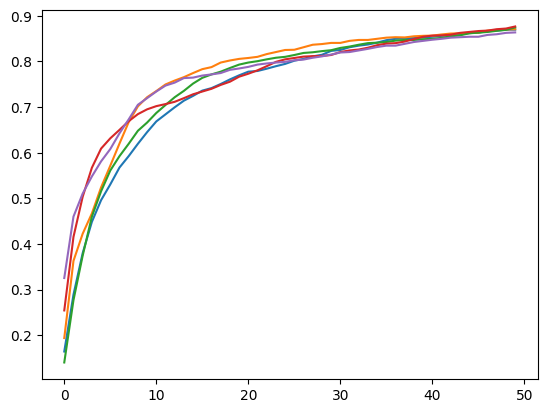

In [28]:
plt.plot(test_accuracies2)

In [29]:
print(losses2)

[[2.297764301300049, 2.3118369579315186, 2.303926467895508, 2.298443555831909, 2.2960526943206787], [2.254791259765625, 2.272294759750366, 2.265395164489746, 2.25264573097229, 2.2525041103363037], [2.2126317024230957, 2.235595941543579, 2.227023124694824, 2.21136736869812, 2.2114243507385254], [2.169389247894287, 2.1966400146484375, 2.187866449356079, 2.169948101043701, 2.1694562435150146], [2.1242620944976807, 2.153444528579712, 2.1453840732574463, 2.1261630058288574, 2.1253020763397217], [2.0774550437927246, 2.1066431999206543, 2.0999834537506104, 2.0797817707061768, 2.079092025756836], [2.029510021209717, 2.0572705268859863, 2.0514132976531982, 2.0311756134033203, 2.0312142372131348], [1.9800323247909546, 2.0063636302948, 2.001317262649536, 1.9813706874847412, 1.9818401336669922], [1.929854154586792, 1.954791784286499, 1.9504247903823853, 1.9310343265533447, 1.931515097618103], [1.8789068460464478, 1.9031082391738892, 1.899155855178833, 1.8803951740264893, 1.881095051765442], [1.827

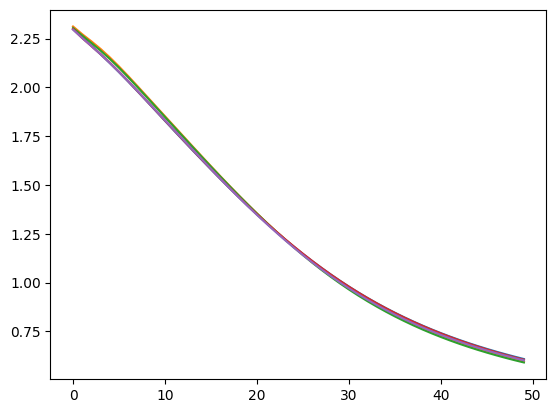

In [30]:
plt.plot(losses2)

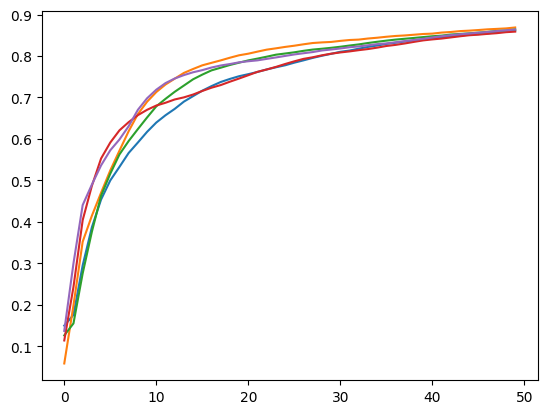

In [31]:
plt.plot(train_accuracies2)

In [32]:
with open(pickle_name+'.pickle', 'wb') as handle:
    pickle.dump(my_pickle_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
labels = []
for _, label in train_loaders[0]:
    labels.append(label)
#print(labels)
#print(classification_report(y_true, y_pred, target_names=target_names))

In [34]:
#Testing pickle

import pickle

try:
    my_pickle_results3 = pickle.load( open( pickle_name+'.pickle', "rb" ) )
    result3 = {}
    result4 = {}
    myResults = my_pickle_results3
except (OSError, IOError) as e:
    my_pickle_results = {}
    resul3 = {}
    result4 = {}

print(my_pickle_results3["p2p"]["train_losses"])

[[2.297764301300049, 2.3118369579315186, 2.303926467895508, 2.298443555831909, 2.2960526943206787], [2.254791259765625, 2.272294759750366, 2.265395164489746, 2.25264573097229, 2.2525041103363037], [2.2126317024230957, 2.235595941543579, 2.227023124694824, 2.21136736869812, 2.2114243507385254], [2.169389247894287, 2.1966400146484375, 2.187866449356079, 2.169948101043701, 2.1694562435150146], [2.1242620944976807, 2.153444528579712, 2.1453840732574463, 2.1261630058288574, 2.1253020763397217], [2.0774550437927246, 2.1066431999206543, 2.0999834537506104, 2.0797817707061768, 2.079092025756836], [2.029510021209717, 2.0572705268859863, 2.0514132976531982, 2.0311756134033203, 2.0312142372131348], [1.9800323247909546, 2.0063636302948, 2.001317262649536, 1.9813706874847412, 1.9818401336669922], [1.929854154586792, 1.954791784286499, 1.9504247903823853, 1.9310343265533447, 1.931515097618103], [1.8789068460464478, 1.9031082391738892, 1.899155855178833, 1.8803951740264893, 1.881095051765442], [1.827

In [35]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-05-14 16:30:41
